In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2 as cv
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input,decode_predictions
from keras import backend as K
from keras.layers import add, Conv2D,MaxPooling2D,UpSampling2D,Input,BatchNormalization, RepeatVector, Reshape
from keras.layers.merge import concatenate
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


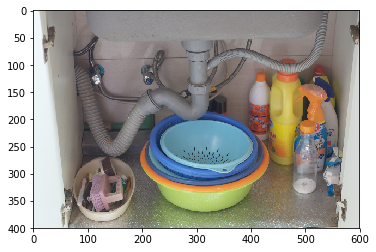

In [2]:
img = cv.imread('/kaggle/input/low-light-proj/Train/high/105.png')  
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)

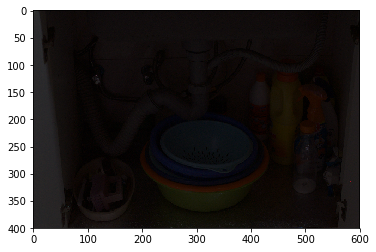

In [3]:
imgl = cv.imread('/kaggle/input/low-light-proj/Train/low/105.png')  
imgl = cv.cvtColor(imgl, cv.COLOR_BGR2RGB)
plt.imshow(imgl)

In [6]:
from math import log10, sqrt 
import cv2 
import numpy as np 

def scores(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    abs_er = np.abs(original - compressed)
    mae = np.mean(abs_er)
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    print ("PSNR: ",psnr,'MSE: ',mse,'MAE: ',mae)


In [7]:
def PreProcessData(imgpath_h,imgpath_l):
    X_=[]
    y_=[]
    for imageDir in os.listdir(imgpath_h):
        img = cv.imread(imgpath_h + imageDir)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img_y = cv.resize(img,(500,500))
        y_.append(img_y)
    for imageDir in os.listdir(imgpath_l):
        img = cv.imread(imgpath_h + imageDir)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img_y = cv.resize(img,(500,500))
        X_.append(img_y)
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_,y_

In [8]:
inp_h = '/kaggle/input/low-light-proj/Train/high/'
inp_l = '/kaggle/input/low-light-proj/Train/low/'

In [9]:
X_,y_ = PreProcessData(inp_h,inp_l)

In [10]:
K.clear_session()
def InstantiateModel(in_):
    
    model_1 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(in_)
    model_1 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_1)
    model_1 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_1)
    
    model_2 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(in_)
    model_2 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_2)
    
    model_2_0 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_2)
    
    model_add = add([model_1,model_2,model_2_0])
    
    model_3 = Conv2D(64,(3,3), activation='relu',padding='same',strides=1)(model_add)
    model_3 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_3)
    model_3 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_3)
    
    model_3_1 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_add)
    model_3_1 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_3_1)
    
    model_3_2 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_add)
    
    model_add_2 = add([model_3_1,model_3_2,model_3])
    
    model_4 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add_2)
    model_4_1 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add)
    #Extension
    model_add_3 = add([model_4_1,model_add_2,model_4])
    
    model_5 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add_3)
    model_5 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_add_3)
    
    model_5 = Conv2D(3,(3,3), activation='relu',padding='same',strides=1)(model_5)
    
    return model_5
    

In [11]:
Input_Sample = Input(shape=(500, 500,3))
Output_ = InstantiateModel(Input_Sample)
Model_Enhancer = Model(inputs=Input_Sample, outputs=Output_)

In [12]:
Model_Enhancer.compile(optimizer="adam", loss='mean_squared_error')
Model_Enhancer.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 500, 500, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 500, 500, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 500, 500, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 500, 500, 32) 4640        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (

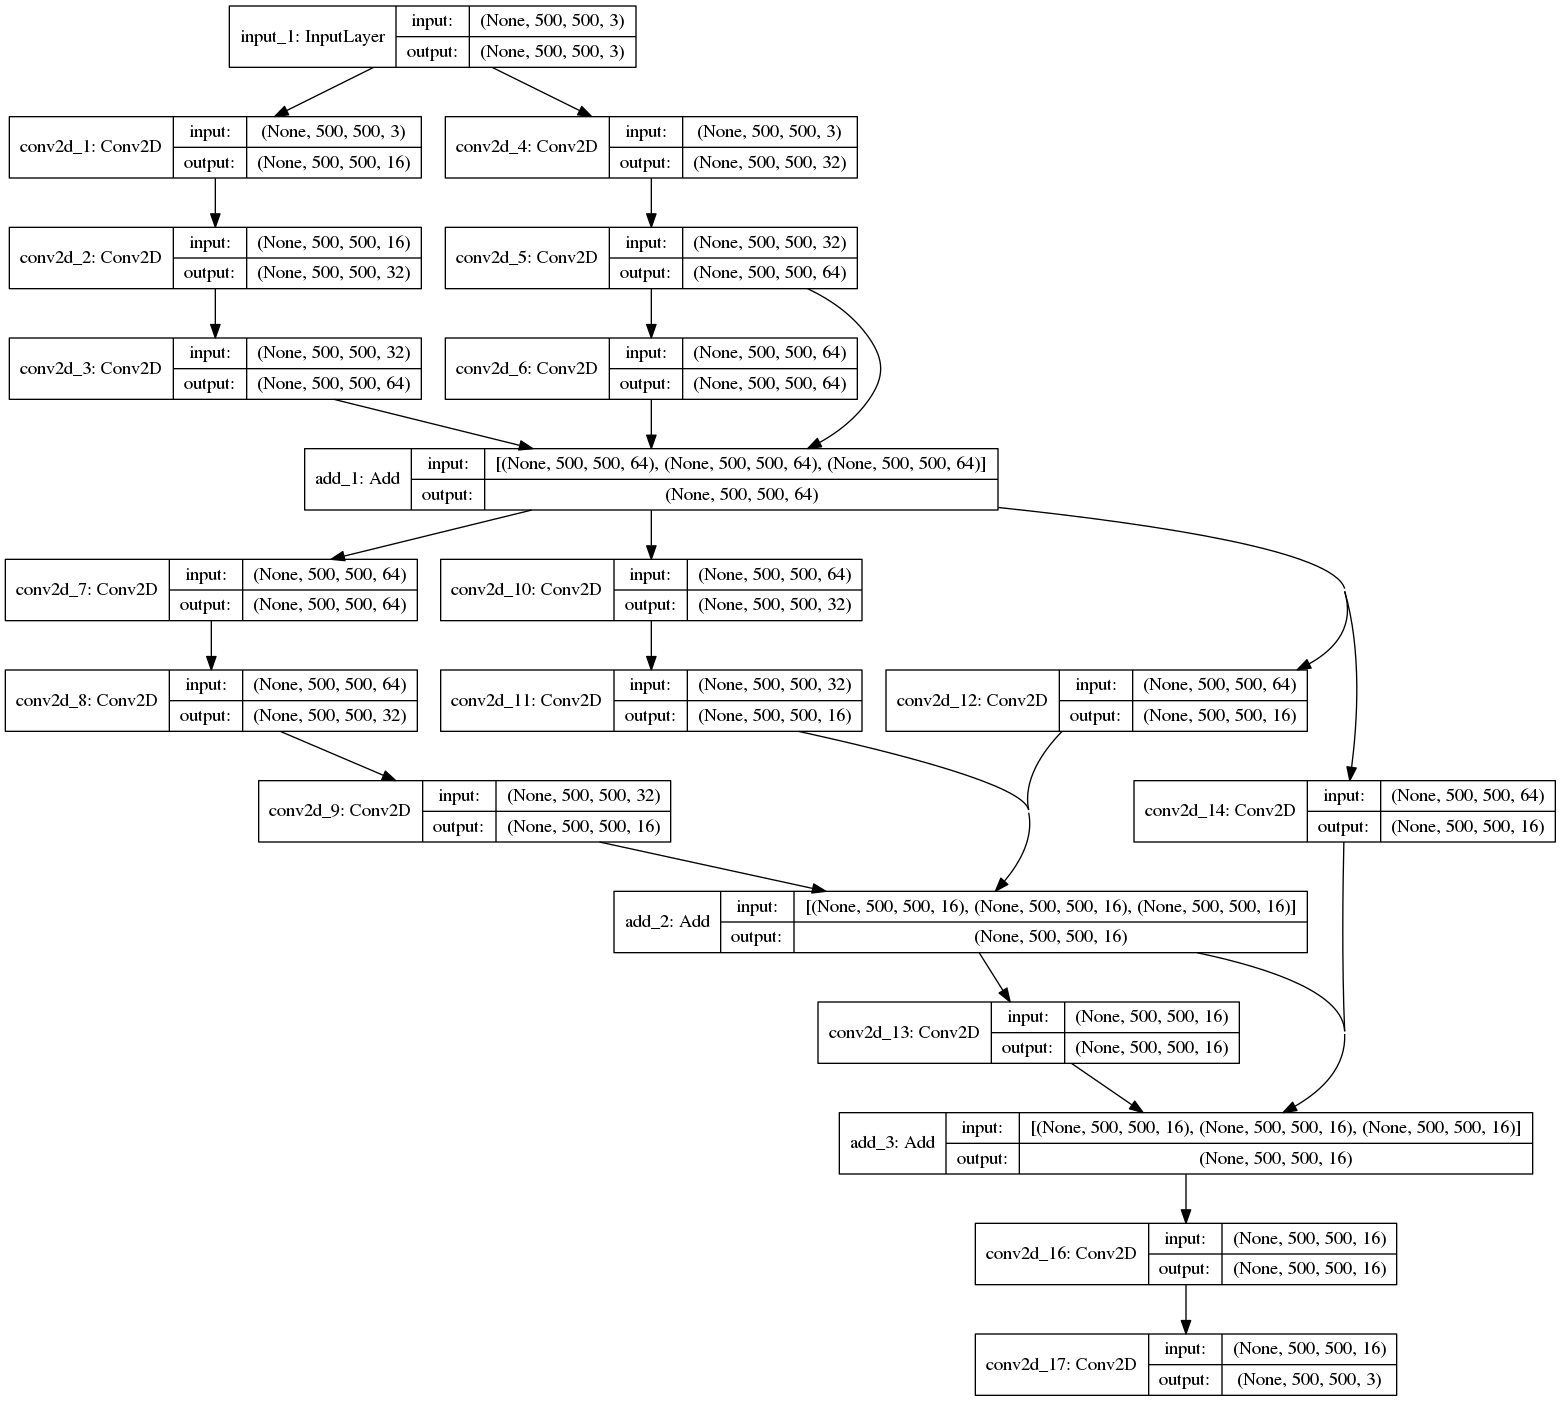

In [13]:
from keras.utils.vis_utils import plot_model
plot_model(Model_Enhancer,to_file='model_.png',show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(retina=True, filename='model_.png')

In [14]:
def GenerateInputs(X,y):
    for i in range(len(X)):
        X_input = X[i].reshape(1,500,500,3)
        y_input = y[i].reshape(1,500,500,3)
        yield (X_input,y_input)
Model_Enhancer.fit_generator(GenerateInputs(X_,y_),epochs=5,verbose=1,steps_per_epoch=97,shuffle=True)

Epoch 1/5
97/97 [==============================] - 684s 7s/step - loss: 1139.3942
Epoch 2/5
97/97 [==============================] - 682s 7s/step - loss: 66.4033
Epoch 3/5
97/97 [==============================] - 684s 7s/step - loss: 35.4748
Epoch 4/5
97/97 [==============================] - 683s 7s/step - loss: 67.1576
Epoch 5/5
97/97 [==============================] - 680s 7s/step - loss: 26.3051


In [15]:
def ExtractTestInput(ImagePath):
    img = cv.imread(ImagePath)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_ = cv.resize(img,(500,500))
    img_ = img_.reshape(1,500,500,3)
    return img_

In [29]:
ImagePath='/kaggle/input/low-light-proj/Train/low/118.png'
image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Enhancer.predict(image_for_test)

In [30]:
Prediction.shape

(1, 500, 500, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


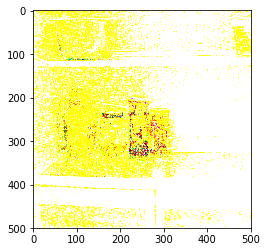

In [31]:
Prediction = Prediction.reshape(500,500,3)
plt.imshow(Prediction)

In [32]:
original.resize(500,500,3)

In [33]:
scores(original,Prediction)

PSNR:  5.696160791281246 MSE:  17517.184 MAE:  121.20181


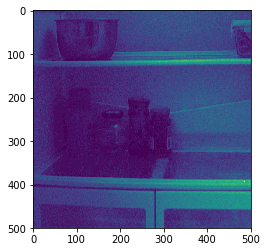

In [34]:
#convert to gray_scale
import numpy as np
import cv2

img_float = Prediction 
if img_float.max() <= 1.0:
    img_float = img_float * 255

img_uint8 = img_float.astype(np.uint8)
if len(img_uint8.shape) == 3 and img_uint8.shape[2] == 3:
    img_gray = cv2.cvtColor(img_uint8, cv2.COLOR_BGR2GRAY)
else:
    img_gray = img_uint8  
cv2.imwrite('grayscale_image.jpg', img_gray)
plt.imshow(img_gray)

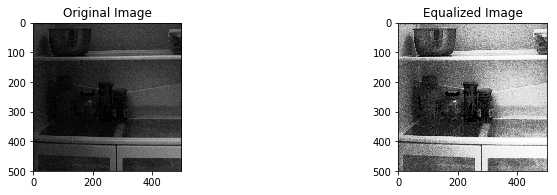

In [36]:
#histogram_equalisation
path = '/kaggle/input/low-light-proj/Train/low/14.png'
image = img_gray

hist, bins = np.histogram(image.flatten(), 256, [0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max() / cdf.max()

cdf_m = np.ma.masked_equal(cdf, 0)
cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())
cdf = np.ma.filled(cdf_m, 0).astype('uint8')

equalized_image = cdf[image]

plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')

plt.subplot(2, 2, 2)
plt.title('Equalized Image')
plt.imshow(equalized_image, cmap='gray')

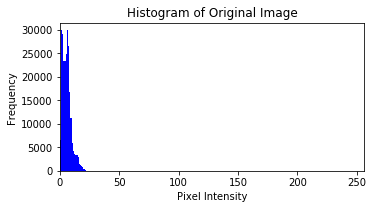

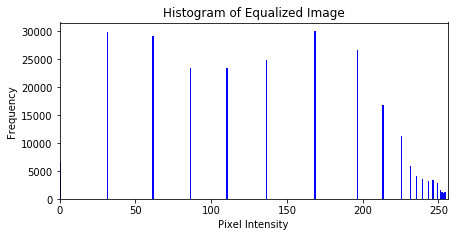

In [52]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 2)
plt.title('Histogram of Original Image')
plt.hist(image.flatten(), 256, [0,256], color='blue')
plt.xlim([0,256])
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 4)
plt.title('Histogram of Equalized Image')
plt.hist(equalized_image.flatten(), 256, [0,256], color='blue')
plt.xlim([0,256])
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

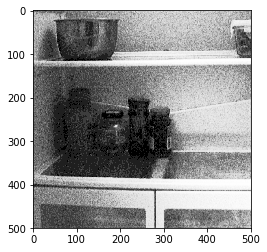

In [53]:
img_color1 = cv2.cvtColor(equalized_image, cv2.COLOR_GRAY2BGR)
plt.imshow(img_color1)

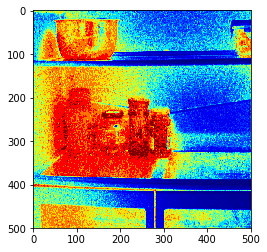

In [57]:
img_colormap = cv2.applyColorMap(equalized_image, cv2.COLORMAP_JET)
plt.imshow(img_colormap)

In [58]:
scores(original,img_color1)

PSNR:  27.871782500208866 MSE:  106.145628 MAE:  130.416972


In [59]:
scores(original,img_colormap)

PSNR:  28.023254985488766 MSE:  102.507316 MAE:  127.44292666666666
